Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [ ]:
NAME = ""
COLLABORATORS = "NONE"

# Partial Differential equations: Finite differences

REFS:
- Franklin, Computational methods for Physics
- Landau y Paez, Computational physics
- Boudreau et al, Applied Computational Physics

\begin{equation}
\nabla^2 V = \left[ \frac{\partial^2 V}{\partial x^2} + \frac{\partial^2 V}{\partial y^2} + \frac{\partial^2 V}{\partial z^2}\right] = -\frac{\rho}{\epsilon_0}
\end{equation}

In 2D, there are several solutions and the actual one depends on the boundary conditions. For example, for the Laplace equation you have

\begin{align}
V(x, y) & = V_0,\\
V(x, y) & = \frac{1}{2} A (x^2 - y^2) + Bx + Cy + D
\end{align}
as solutions. 

A [finite difference](https://en.wikipedia.org/wiki/Finite_difference) method discretizes the derivatives on a grid. For instance, using the central difference it is possible to rewrite the 2D Poisson equation as ([Laplace equation](https://en.wikipedia.org/wiki/Laplace%27s_equation) corresponds to $\rho = 0$ 

\begin{equation}
\frac{V(x_i + \Delta x, y_j) - 2V(x_i, y_j) + V(x_i - \Delta x, y_j)}{\Delta x^2} + \frac{V(x_i, y_j + \Delta y) - 2V(x_i, y_j) + V(x_i, y_j - \Delta y)}{\Delta y^2} = -\frac{\rho(x_i, y_j)}{\epsilon_0}.
\end{equation}

which can be rewritten as  (let's assume $\Delta x = \Delta y = \Delta$)

\begin{equation}
\frac{V_{i+1, j} - 2V_{i, j} + V_{i-1, j}}{\Delta^2} + \frac{V_{i,j+1} - 2V_{i, j} + V_{i, j-1}}{\Delta^2} = -\frac{\rho_{i, j}}{\epsilon_0},
\end{equation}

and, therefore

\begin{equation}
V_{i+1, j} + V_{i-1, j} + V_{i,j+1} + V_{i, j-1} - 4V_{i, j} = -\frac{\rho_{i, j}\Delta^2}{\epsilon_0}.
\end{equation}

This can be seen in two ways: as a matrix equation or as an equation showing that the value at a given position, $V_{i, j}$, is kind of an average of the surrounding neighbors and the source term ([Jacobi method](https://en.wikipedia.org/wiki/Jacobi_method)), as seen (ref: https://barbagroup.github.io/essential_skills_RRC/laplace/1/#laplaces-equation)

<img src="https://barbagroup.github.io/essential_skills_RRC/laplace/figures/laplace.svg">

The first approach can be solved by using the typical matrix methods (on the banded matrix obtained), while the second one gives raise to the [relaxation method](https://en.wikipedia.org/wiki/Relaxation_(iterative_method)), where you sweep the matrix several times until stabilization is achieved. 



# Relaxation solution
Let's solve the Laplace problem ($\rho = 0$) using both methods with a simple example. Fix the boundaries as

\begin{align}
V(x, 0) &= \sin(\pi x),\\
V(x, a) &= 0, \\
V(0, y) &= 0, \\
V(a, y) &= 0, \\
\end{align}

with $x, y \in [0, 1]$, and $a $ any value on the border. These are called [Dirichlet boundary conditions](https://en.wikipedia.org/wiki/Dirichlet_boundary_condition) (where you specify the function values at the boundary). Finally, use at least $N_x = N_y = 25$, so $\Delta = 1/25$, $x_i = x_0 + i\Delta, y_j = y_0 + j\Delta$. We need to solve the equation

\begin{equation}
V_{i, j} = \frac{V_{i+1, j} + V_{i-1, j} + V_{i,j+1} + V_{i, j-1}}{4}.
\end{equation}

To do so, we apply this relationship to each point in the grid, without overwriting the boundary conditions, and we do that until the values are not changing much. Firs, let's define the problem conditions (to be changed later)

In [ ]:
# Global problem definition
import numpy as np
def setup_problem(N):
    XMIN = 0.0
    YMIN = 0.0
    DELTA = 1.0/N
    X = XMIN + DELTA*np.arange(0, N)
    Y = XMIN + DELTA*np.arange(0, N)
    return X, Y

Now create a function for the boundary conditions

In [ ]:
# Boundary conditions
def bc(matrix, x, y):
    matrix[:, 0] = np.sin(np.pi*x)
    matrix[:,-1] = 0
    matrix[0 ,:] = 0
    matrix[-1,:] = 0


And this will be a simple example for single iteration step. In this case, we are avoiding the external walls since they are boundary conditions. We are using the fast numpy notation (see also https://becksteinlab.physics.asu.edu/learning/76/phy494-computational-physics?wchannelid=bp7lsp6dmx&wmediaid=284owsl3dp), but of course you can use loops (specially for more complex boundary problems)

In [ ]:
def jacobiI(matrix):
    N = matrix.shape[0]
    matrix[1:-1,1:-1]= 0.25*(matrix[:-2,1:-1] + matrix[2:,1:-1] + 
                             matrix[1:-1,2:] + matrix[1:-1,:-2])
def jacobiN(matrix):
    N = matrix.shape[0]
    for ii in range(0,N):
        for jj in range(0,N):#(ii,N):
            if ii == 0 or jj == 0 or ii == N-1 or jj == N-1:
                continue
            matrix[ii,jj]= 0.25*(matrix[ii+1,jj] + matrix[ii-1,jj] + 
            matrix[ii,jj+1] + matrix[ii,jj-1])


Finally, let's perform some iterations to check if the system is converging somewhere

In [ ]:
import time
#Vectorizar tal que recorra los diferentes métodos
def solve_system(N, niter, iter_method):
    
    X, Y = setup_problem(N)
    V = np.zeros((N, N))
    bc(V, X, Y)
    t = np.arange(niter,dtype = np.float32)


    # Example iteration
    for step in range(niter):
        #print(V)
        t0 = time.time()
        iter_method(V)
        t1 = time.time()
        dif=t0-t1
        #Se almacena la info del tiempo transcurrido
        t[step] = dif
        #print(V)

    
    print(f"Metodo: {iter_method}") 
    print(f"Total time iterating by iteration: {t}")
    print(f"Media: {np.mean(t)} \n Desviación Estandar: {np.std(t)}\n\n")
          
solve_system = np.vectorize(solve_system)

In [ ]:
solve_system(N=500, niter=5, iter_method=[jacobiN,jacobiI])

Metodo: <function jacobiN at 0x7fd7688b4cb0>
Total time iterating by iteration: [-0.36414814 -0.34226513 -0.46280694 -0.34334326 -0.35112834]
Media: -0.3727383613586426 
 Desviación Estandar: 0.04570738226175308


Metodo: <function jacobiN at 0x7fd7688b4cb0>
Total time iterating by iteration: [-0.35665107 -0.38722634 -0.7489946  -0.7726791  -0.68854856]
Media: -0.5908199548721313 
 Desviación Estandar: 0.18106809258460999


Metodo: <function jacobiI at 0x7fd7688b4050>
Total time iterating by iteration: [-0.00269651 -0.00152302 -0.00150371 -0.0014689  -0.00148582]
Media: -0.0017355919117107987 
 Desviación Estandar: 0.0004807993827853352




array([None, None], dtype=object)

Or let's check it  graphically

In [ ]:
import matplotlib.pyplot as plt
def solve_system(N, niter, iter_method):
    X, Y = setup_problem(N)
    V = np.zeros((N, N))
    bc(V, X, Y)
    # Example iteration
    for step in range(niter):
        #plt.imshow(V)
        plt.show()
        iter_method(V)
        plt.imshow(V)
        plt.show()

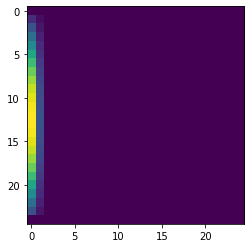

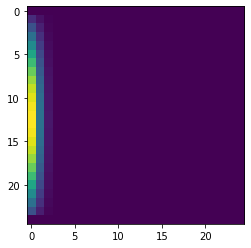

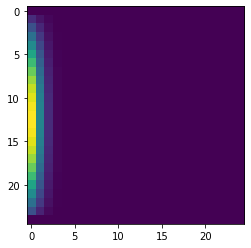

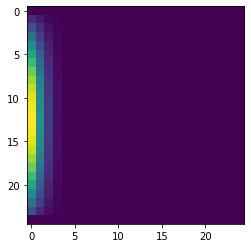

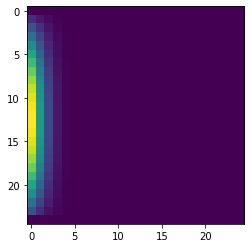

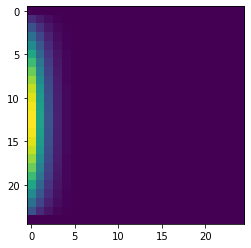

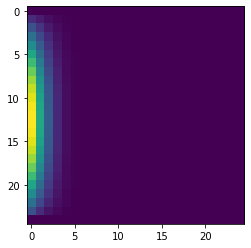

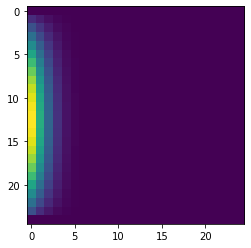

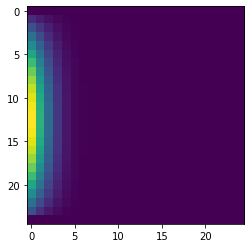

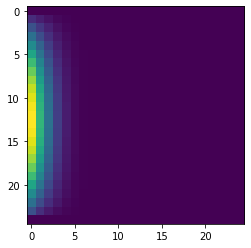

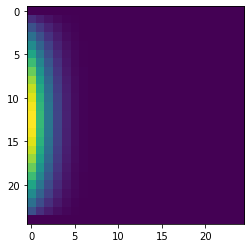

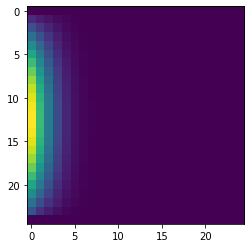

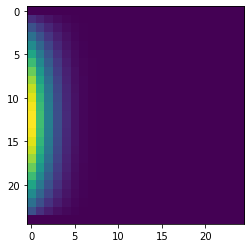

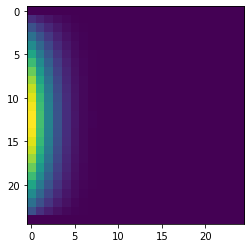

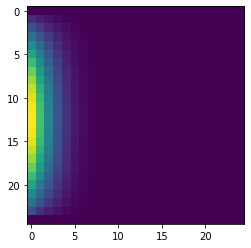

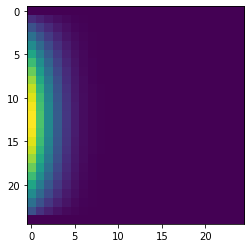

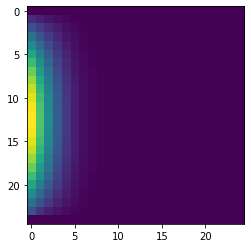

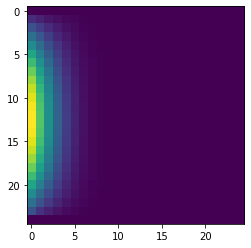

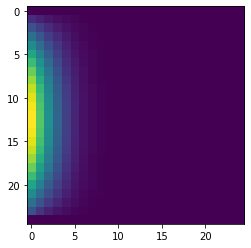

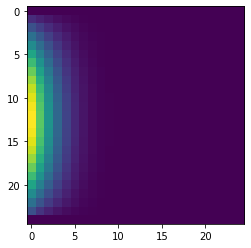

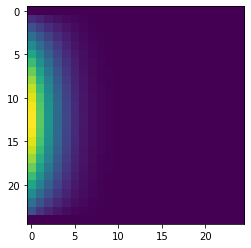

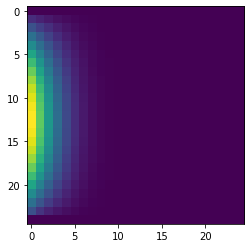

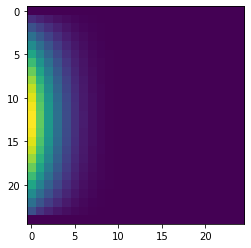

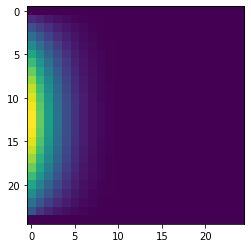

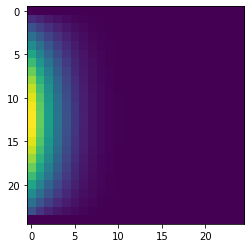

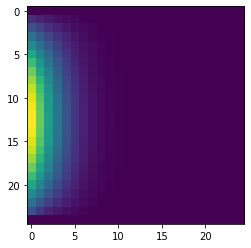

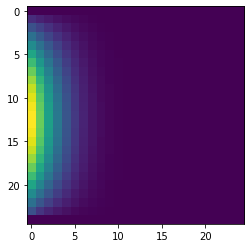

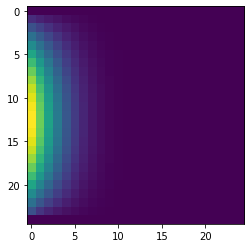

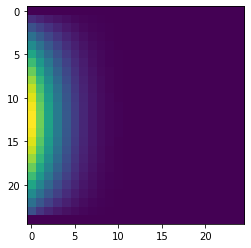

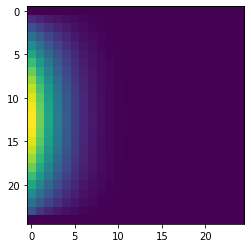

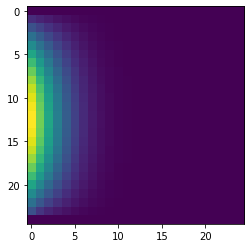

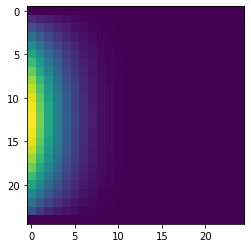

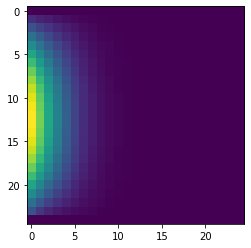

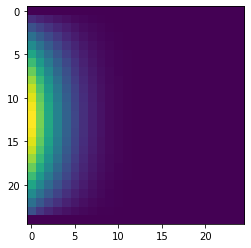

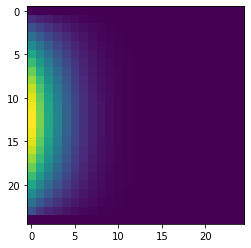

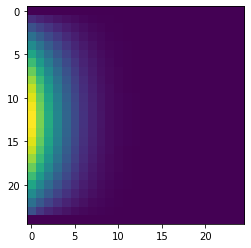

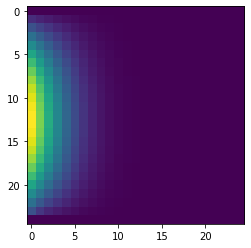

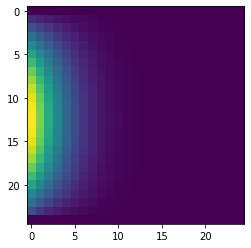

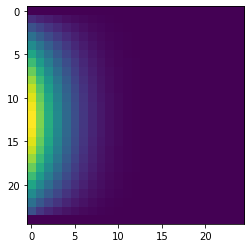

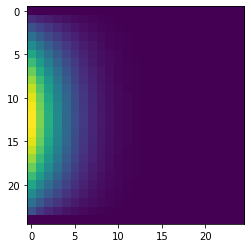

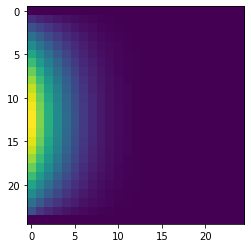

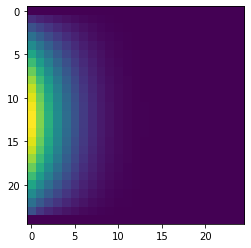

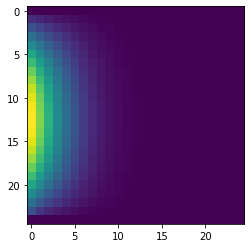

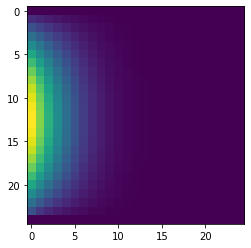

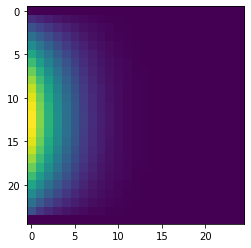

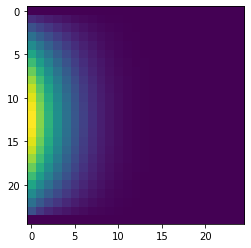

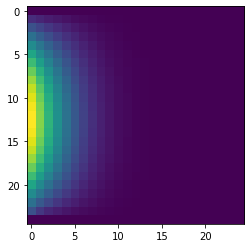

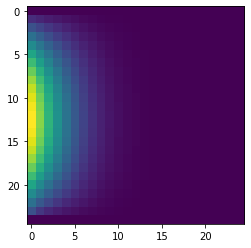

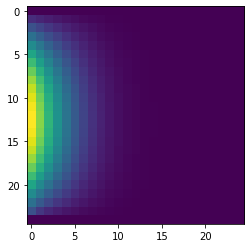

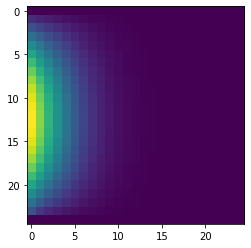

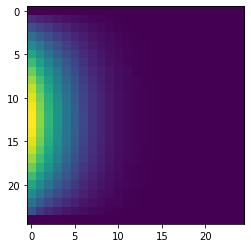

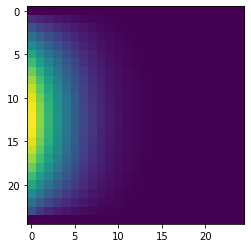

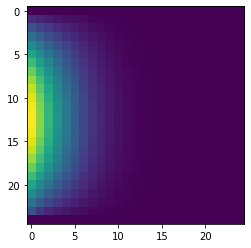

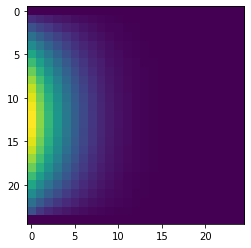

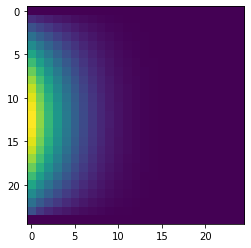

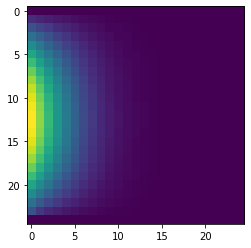

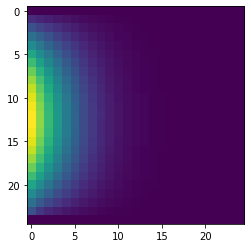

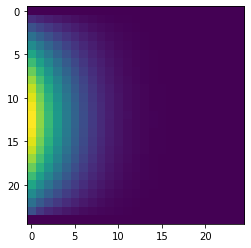

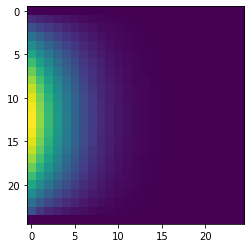

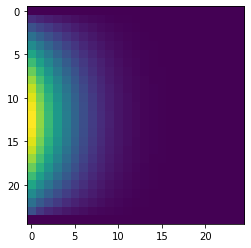

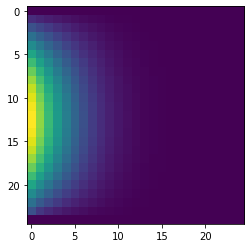

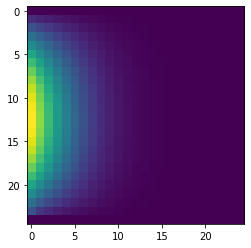

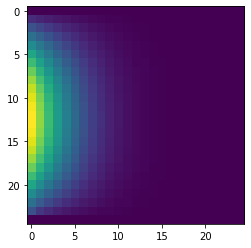

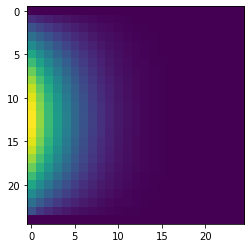

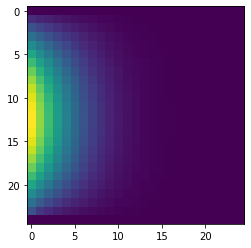

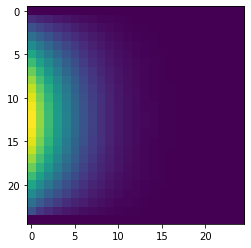

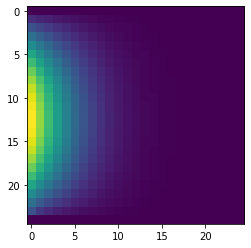

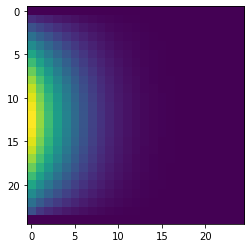

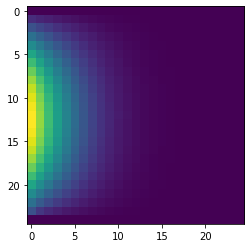

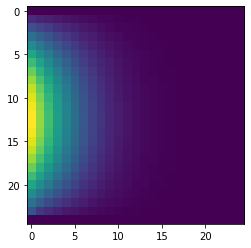

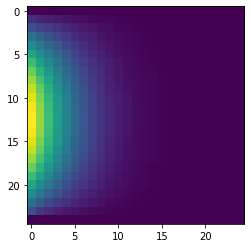

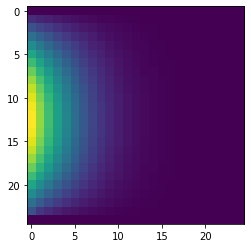

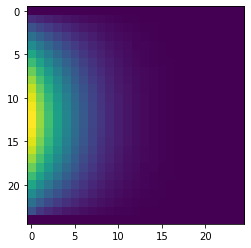

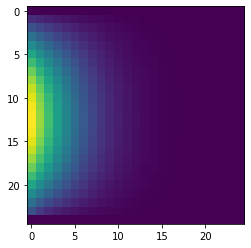

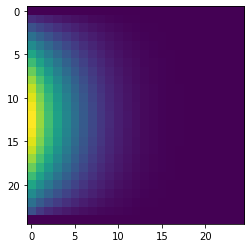

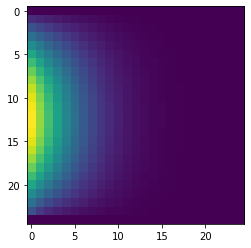

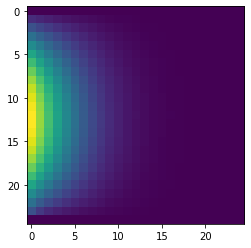

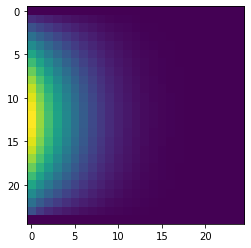

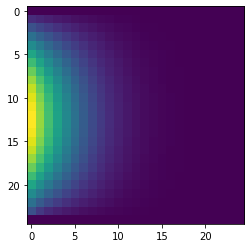

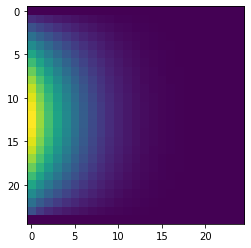

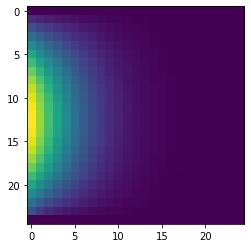

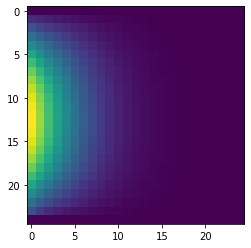

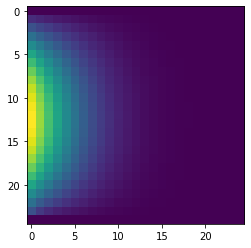

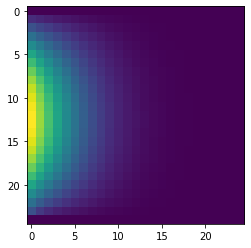

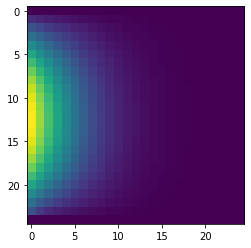

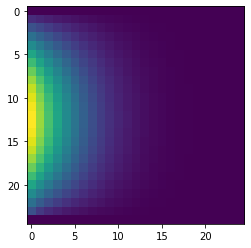

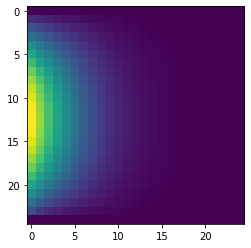

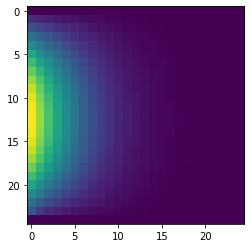

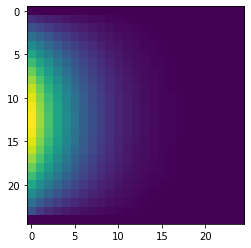

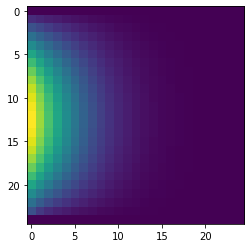

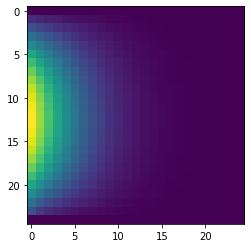

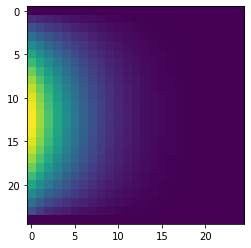

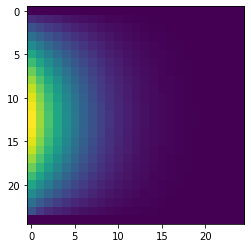

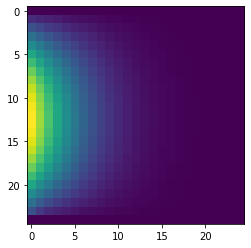

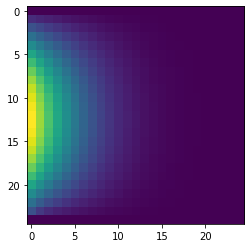

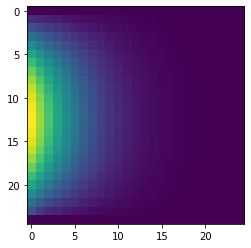

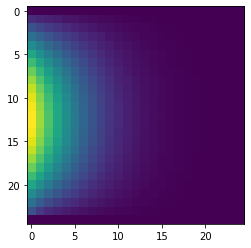

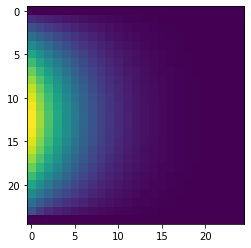

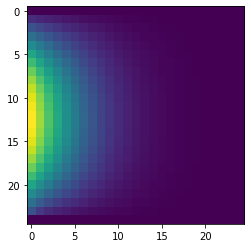

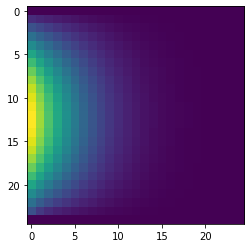

In [ ]:
solve_system(N=25, niter=100, iter_method=jacobiI)

To have a quantitative relaxation index, we could compare the new values with the old ones, so let's redefine the iteration step method to return the estimator 

In [ ]:
def jacobi2(matrix):
    matrix_old = matrix.copy() # Might be slow, creates copies all the time
    N = matrix.shape[0]
    for ii in range(0,N):
        for jj in range(0,N):#(ii,N):
            if ii == 0 or jj == 0 or ii == N-1 or jj == N-1:
                continue
            new = 0.25*(matrix[ii+1,jj] + matrix[ii-1,jj] + 
            matrix[ii,jj+1] + matrix[ii,jj-1])
            sumdiff = abs(matrix[ii,jj] - new )
            matrix[ii,jj] = new 
    diff = np.linalg.norm(matrix- matrix_old)
    return diff


In [ ]:
def solve_system(N, niter, iter_method):
    X, Y = setup_problem(N)
    V = np.zeros((N, N))
    bc(V, X, Y)
    diff = np.zeros(niter)
    # Example iteration
    for step in range(niter):
        diff[step] = iter_method(V)
    return diff

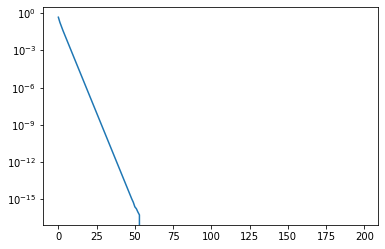

In [ ]:
diff = solve_system(N=5, niter=200, iter_method=jacobi2)
plt.plot(diff)
#plt.xscale("log")
plt.yscale("log")

Notice that the convergence depends strongly on the space resolution:

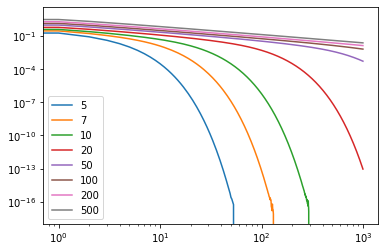

In [ ]:
for N in [5, 7, 10, 20, 50 , 100, 200, 500]:
    diff = solve_system(N=N, niter=1000, iter_method=jacobi2)
    plt.plot(diff, label=f"{N}")
plt.xscale("log")
plt.yscale("log")
plt.legend()

We can also use the Gauss-Seidel approach by overwriting the original matrix (and even SOR) to speed up convergence 

<img src="https://aquaulb.github.io/book_solving_pde_mooc/_images/GSgrid_e.png" width=400> 

REF: [https://aquaulb.github.io/book_solving_pde_mooc/solving_pde_mooc/notebooks/05_IterativeMethods/05_01_Iteration_and_2D.html](https://aquaulb.github.io/book_solving_pde_mooc/solving_pde_mooc/notebooks/05_IterativeMethods/05_01_Iteration_and_2D.html)

You might need to use a for loop

In [ ]:
def gs(matrix):
    matrix_old = matrix.copy() # Might be slow, creates copies all the time
    N = matrix.shape[0]
    for ii in range(0,N):
        for jj in range(0,N):#(ii,N):
            if ii == 0 or jj == 0 or ii == N-1 or jj == N-1:
                continue
            matrix[ii,jj]= 0.25*(matrix[ii+1,jj] + matrix[ii-1,jj] + 
            matrix[ii,jj+1] + matrix[ii,jj-1])
    rij = matrix - matrix_old
    diff = np.linalg.norm(rij)
    return diff


5
7
10
20
50
100
200
500


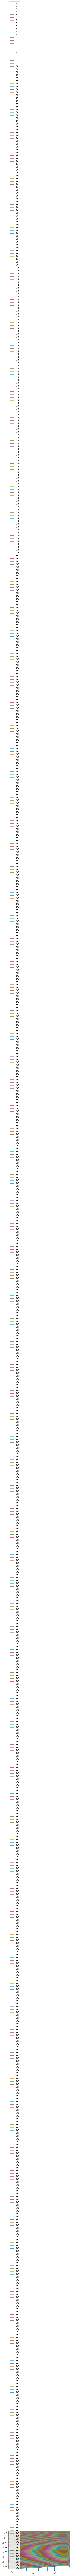

In [ ]:
for N in [5, 7, 10, 20, 50 , 100, 200, 500]:
    print(N)
    diff = solve_system(N=N, niter=1000, iter_method=gs)
    plt.plot(diff, label=f"{N}")
plt.xscale("log")
plt.yscale("log")
plt.legend()

# A performance discussion 

But this loop version is very slow. When you need to optimize something, you need to measure it (using profilers). Here we will use https://jakevdp.github.io/PythonDataScienceHandbook/01.07-timing-and-profiling.html  and https://mortada.net/easily-profile-python-code-in-jupyter.html . 

In [ ]:
%%time 
tmp = solve_system(N=100, niter=1000, iter_method=gs)

CPU times: user 13.5 s, sys: 49.3 ms, total: 13.5 s
Wall time: 13.5 s


We can optimize with `numba` (see https://stackoverflow.com/questions/61161072/optimizing-vectorized-operations-made-by-sections-in-numpy): 

In [ ]:
!conda install -y numba
!pip install numba

/bin/bash: conda: command not found
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from numba import jit ,njit

@jit#(parallel=True)
def gs_opt(matrix):
    matrix_old = matrix.copy() # Might be slow, creates copies all the time
    N = matrix.shape[0]
    for ii in range(0,N):
        for jj in range(0,N):#(ii,N):
            if ii == 0 or jj == 0 or ii == N-1 or jj == N-1:
                continue
            matrix[ii,jj]= 0.25*(matrix[ii+1,jj] + matrix[ii-1,jj] + 
            matrix[ii,jj+1] + matrix[ii,jj-1])
    rij = matrix - matrix_old
    diff = np.linalg.norm(rij)
    return diff

In [ ]:
%%time 
tmp = solve_system(N=100, niter=1000, iter_method=gs_opt)

CPU times: user 2.78 s, sys: 60.7 ms, total: 2.84 s
Wall time: 3.67 s


5
7
10
20
50
100
200
500


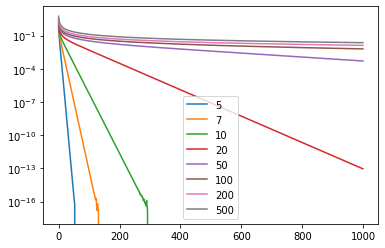

In [ ]:
for N in [5, 7, 10, 20, 50 , 100, 200, 500]:
    print(N)
    diff = solve_system(N=N, niter=1000, iter_method=gs_opt)
    plt.plot(diff, label=f"{N}")
#plt.xscale("log")
plt.yscale("log")
plt.legend()

# Plotting the solution
Now let's plot the actual solution

In [ ]:
def solve_system(N, niter, iter_method):
    X, Y = setup_problem(N)
    V = np.zeros((N, N))
    bc(V, X, Y)
    diff = np.zeros(niter)
    # Example iteration
    for step in range(niter):
        diff[step] = iter_method(V)
    return V

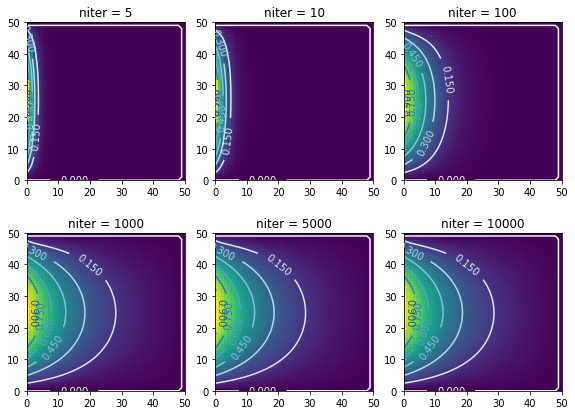

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(8,6))
ax = ax.flatten()
for ii, niter in enumerate([5, 10, 100, 1000, 5000, 10000]):
    V = solve_system(N=50, niter=niter, iter_method=gs_opt)
    ax[ii].set_aspect('equal', 'box')
    ax[ii].pcolormesh(V)
    ax[ii].set_title(f"niter = {niter}")
    CS = ax[ii].contour(V, cmap='Blues')
    ax[ii].clabel(CS, CS.levels, inline=True)
fig.tight_layout()


# Exercise: Plane capacitor
Now , besides the given boundary conditions, add two lines representing a plane capacitor, with opposite voltages of $\pm 3$ volts, with length $2L_y/3$, at $L_x/3$ and $2L_x/3$. Plot the final solution as a 2D map and as a 3D map. 

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: ignored

# Exercise: circular ring
Now , besides the given boundary conditions, add a circular ring with constant voltage of 3 volts and radius $L_x/4$. Plot the final solution as a 2D map and as a 3D map. 

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

# Exercise: Plot the electrical field
For any of the previous examples, use (for example) a quiver plot to plot the electric field, defined as
\begin{equation}
\vec E = -\vec\nabla V
\end{equation}
See https://nbviewer.org/urls/www.numfys.net/media/notebooks/relaxation_methods.ipynb

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

# Exercise: Add two square charges
Solve the Poisson equation with two square charges of size $L_x/10$ on the diagonal. Use $\epsilon_0 = 1$

# Exercise: Implement over-relaxation
Calibrate $\omega$  (see https://en.wikipedia.org/wiki/Successive_over-relaxation)

In [ ]:
from numba import jit
@jit
def gs_sor_opt(matrix, omega):
    matrix_old = matrix.copy() # Might be slow, creates copies all the time
    gs_opt(matrix)
    rij = matrix - matrix_old
    matrix = matrix_old + omega*rij
    rij = matrix - matrix_old
    diff = np.linalg.norm(rij)
    return diff
    #return gs_opt(matrix)

In [ ]:
#for N in [5, 7, 10, 20, 50 , 100, 200, 500]:
for N in [5]:
    print(N)
    OMEGA=1.9
    diff = solve_system(N=N, niter=1000, iter_method=lambda m: gs_sor_opt(m, OMEGA))
    plt.plot(diff, label=f"{N=}")
plt.xscale("log")
plt.yscale("log")
plt.legend()

# Exercise: Stop after tolerance is achieved
Modify the iteration  procedure to stop after some given precision has been achieved

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()